In [99]:
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
import warnings
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
warnings.simplefilter(action='ignore', category=FutureWarning)


In [100]:
X = pd.read_csv('data/train.csv', index_col='id')
X_bis = pd.read_csv('data/train_bis.zip')
X = pd.concat([X, X_bis], ignore_index=True)
y = X.pop('outcome')
X_test = pd.read_csv('data/test.csv', index_col='id')
X.shape, y.shape, X_test.shape

((1534, 27), (1534,), (824, 27))

In [101]:
X.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes


In [102]:
category_cols = X.select_dtypes('object').columns
numeric_cols = X.select_dtypes('number').columns
assert(len(category_cols) + len(numeric_cols) == len(X.columns))

## Categorical values checking

We check if some values are contained in the test data and not in the train data for object columns.
We replace the values in test and not in train by the most common value in test.

In [103]:
def build_missing_term_dict(cols, X_train, X_test):
    """Find the values the test set that are not in the training set."""
    missing_term_dict = {}
    for col in cols:
        missing_values = list(set(X_test[col].unique()) - set(X_train[col].unique()))
        if missing_values:
            missing_term_dict[col] = missing_values
    return missing_term_dict

In [104]:
missing_terms = build_missing_term_dict(category_cols, X, X_test)
missing_terms

{'pain': ['moderate']}

In [105]:
# Replace missing terms with 'Nan'
for key, val in missing_terms.items():
    X_test[key] = X_test[key].replace(val, np.nan)

## Feature selection
We can start by analyzing the repartition of each features.
### categories

In [106]:
category_cols

Index(['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion',
       'cp_data'],
      dtype='object')

16


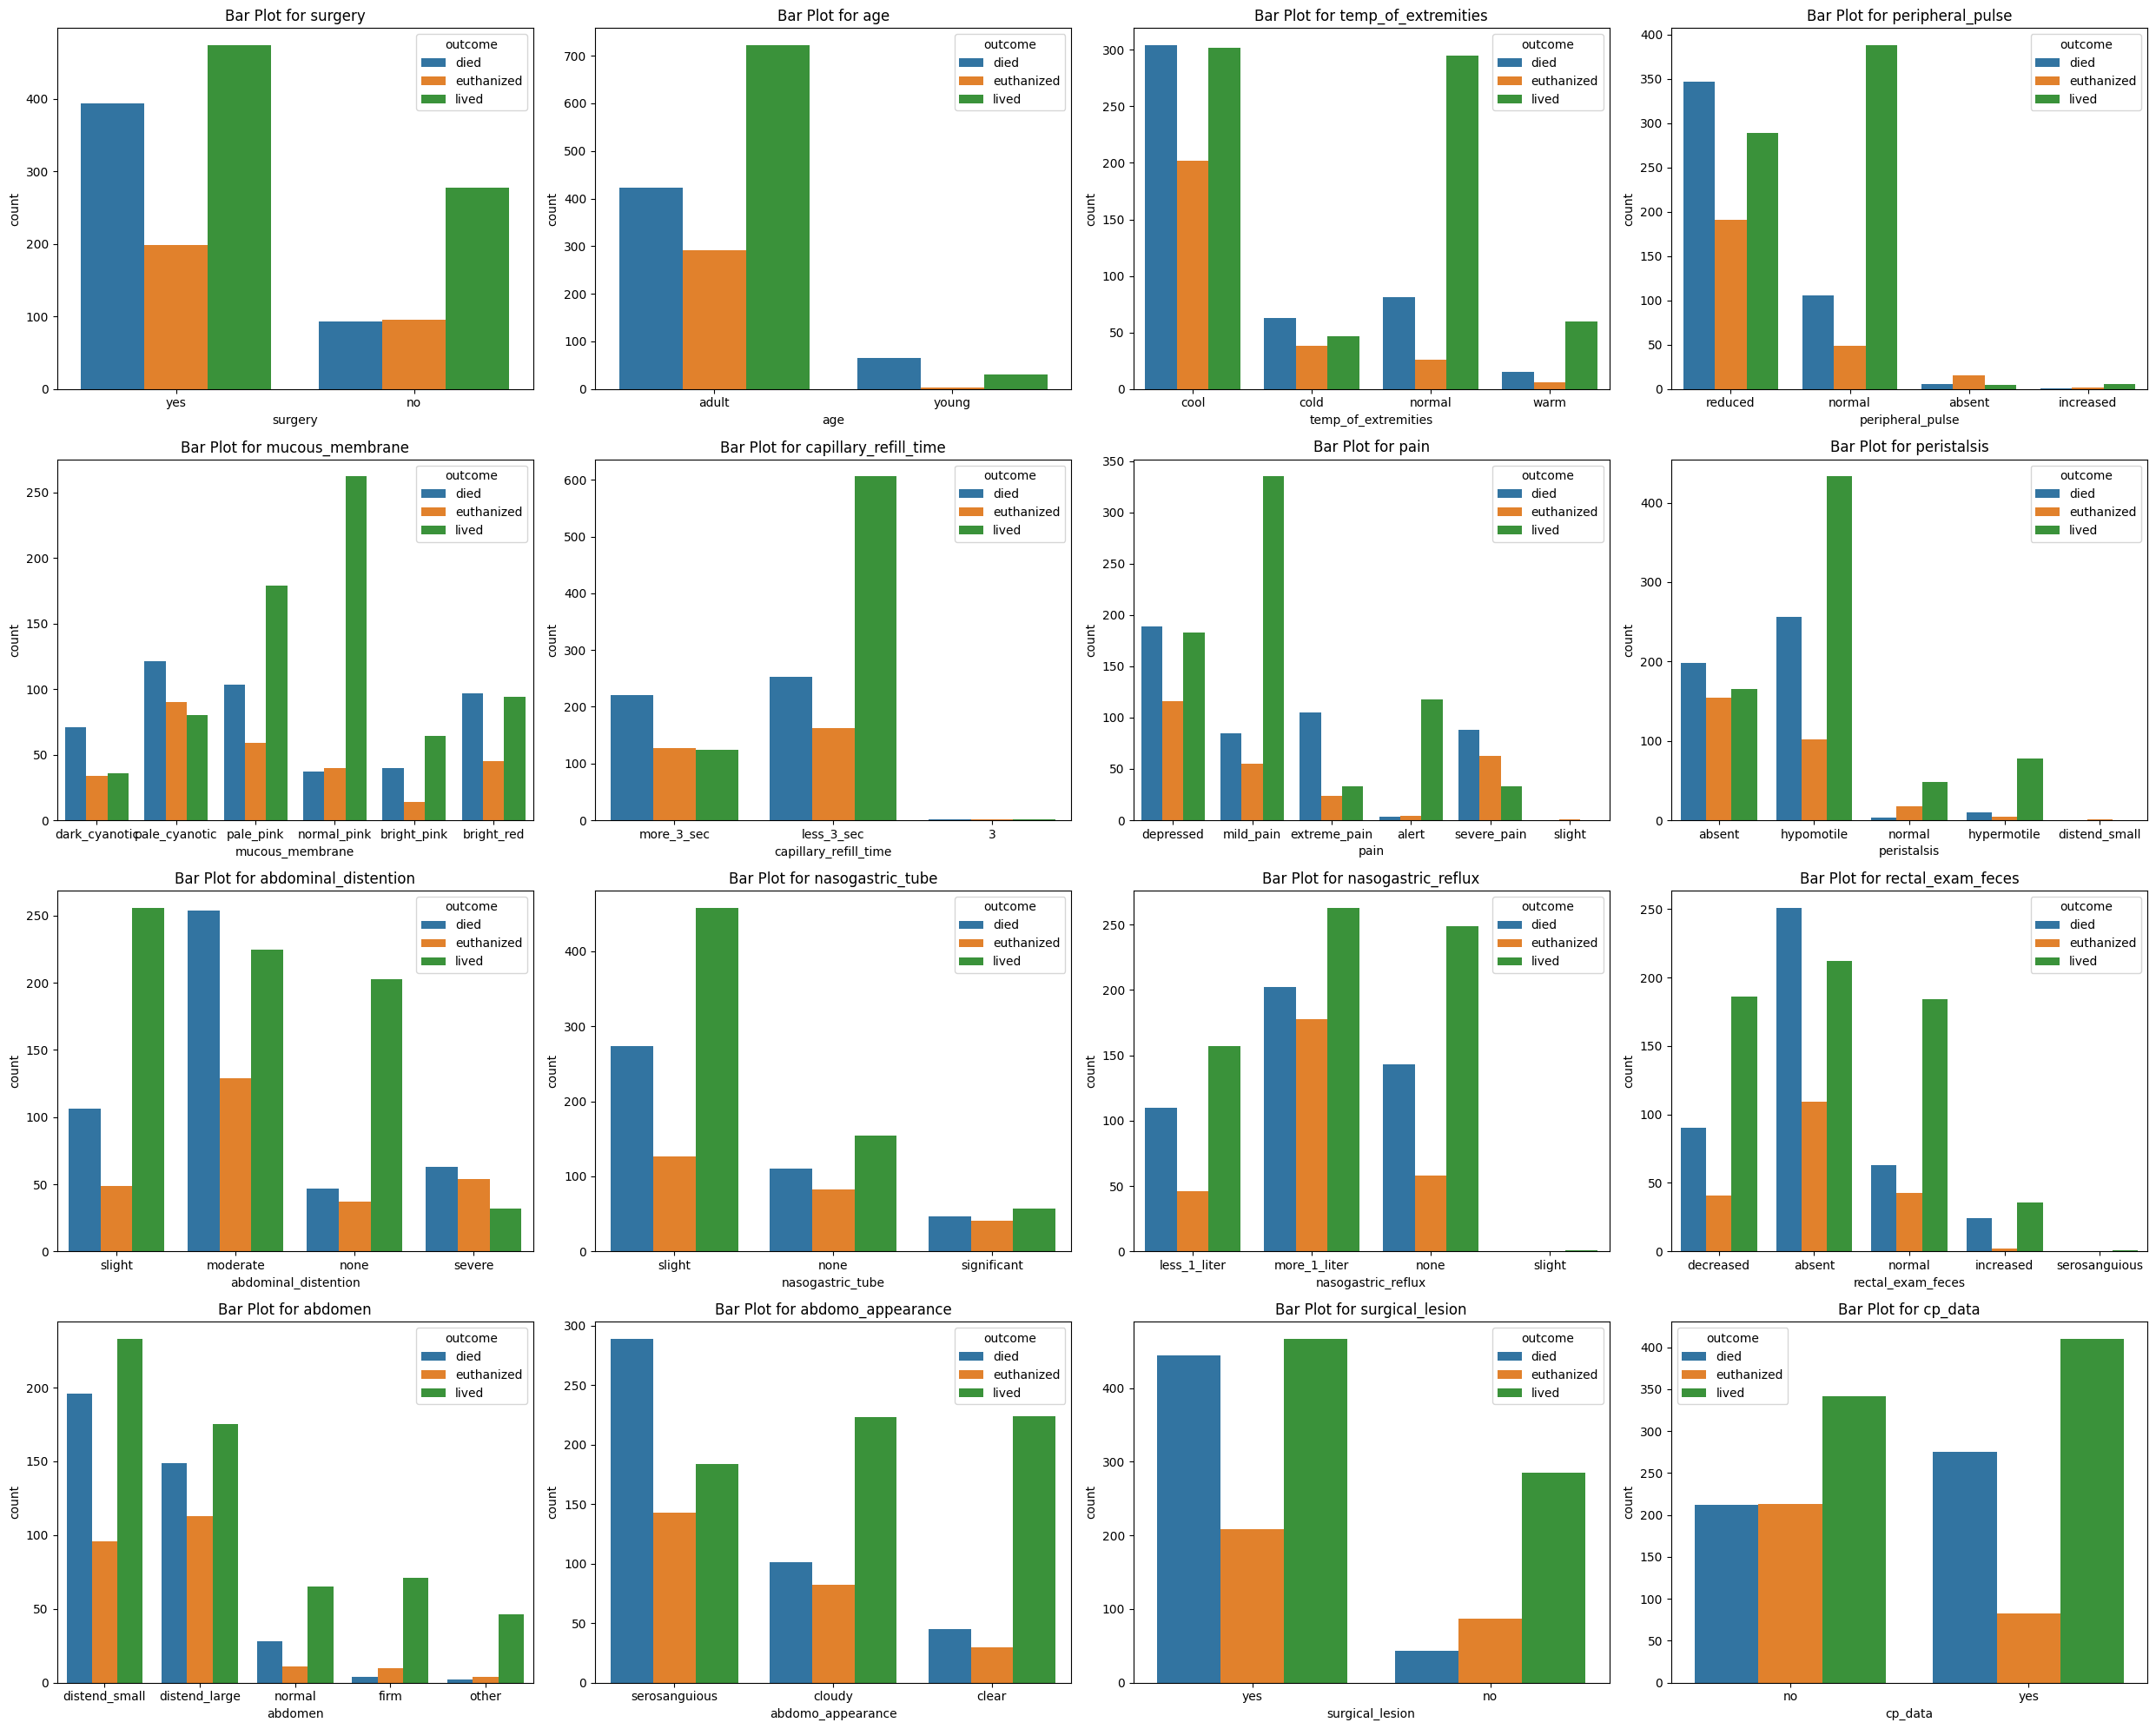

In [107]:

print(len(category_cols))
fig, axes = plt.subplots(4, 4, figsize=(25, 20))
# Flatten the axes array for easier iteration
axes = axes.flatten()
for i, cat in enumerate(category_cols):
    sns.countplot(x=X[cat], hue=y, ax=axes[i])
    axes[i].set_title(f"Bar Plot for {cat}")
plt.tight_layout()
# Show the plots
plt.show()

We see that some features might have an important influence on the outcome, for example the age or surgery. In the end we decide to keep every categories at the moment.
We will however need to encode them.


surgery: ['yes' 'no'] 

age: ['adult' 'young']

temp_of_extremities: ['cool' 'cold' 'normal' 'warm' nan]

peripheral_pulse: ['reduced' 'normal' nan 'absent' 'increased']

mucous_membrane: ['dark_cyanotic' 'pale_cyanotic' 'pale_pink' 'normal_pink' 'bright_pink'
 'bright_red' nan]

capillary_refill_time: ['more_3_sec' 'less_3_sec' nan '3']

pain: ['depressed' 'mild_pain' 'extreme_pain' 'alert' 'severe_pain' nan 'slight']

peristalsis: ['absent' 'hypomotile' 'normal' 'hypermotile' nan 'distend_small']

abdominal_distention: ['slight' 'moderate' 'none' 'severe' nan]

nasogastric_tube: ['slight' 'none' 'significant' nan]

nasogastric_reflux: ['less_1_liter' 'more_1_liter' 'none' nan 'slight']

rectal_exam_feces: ['decreased' 'absent' nan 'normal' 'increased' 'serosanguious']

abdomen: ['distend_small' 'distend_large' 'normal' 'firm' nan 'other']

abdomo_appearance: ['serosanguious' 'cloudy' 'clear' nan]

surgical_lesion: ['yes' 'no']

cp_data: ['no' 'yes']

The ordered ones will be: 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'rectal_exam_feces', 'abdomen', 'abdomo_appearance'

We the define the following orderings encoding


In [108]:
# ordinal features
temp_of_extremities= {'cool':0,'cold':1 ,'normal':2, 'warm':3}
peripheral_pulse= {'absent':0,'reduced':1, 'normal':2  ,'increased':3}
mucous_membrane= {"normal_pink": 0,"bright_pink": 1,"pale_pink": 2, "bright_red": 3, "pale_cyanotic": 4, "dark_cyanotic": 5 }
capillary_refill_time= {'less_3_sec':0 , '3':1 ,'more_3_sec':2}
pain= {'slight':0, 'depressed':1 ,'mild_pain':2,'alert':3 ,'severe_pain':4,'extreme_pain':5 }
peristalsis= {'absent':0,'normal':1,'distend_small':2, 'hypomotile':3 ,'hypermotile':4 }
abdominal_distention= {'none':0, 'slight' :1,'moderate' :2,'severe':3}
nasogastric_tube= {'none':0, 'slight' :1,'significant':2}
nasogastric_reflux= {'none':0 , 'slight':1, 'less_1_liter':2, 'more_1_liter':3}
rectal_exam_feces= {'absent' :0, 'decreased':1,  'normal':2, 'increased':3 ,'serosanguious':4}
abdomen = {"other": 0,"firm": 1,"normal": 2,"distend_large": 3, "distend_small": 4}
abdomo_appearance = {'clear':0, 'serosanguious':1 ,'cloudy':2}
# non ordinal features
surgery = {'no':0, 'yes':1}
age = {'adult':0, 'young':1}
surgical_lesion = {'no':0, 'yes':1}
cp_data = {'no':0, 'yes':1}
outcome = {'lived':0, 'died':1 ,'euthanized':2}
outcome_reverse = {0:'lived', 1:'died' ,2:'euthanized'}

category_mapping = {'temp_of_extremities':temp_of_extremities, 'peripheral_pulse':peripheral_pulse, 'mucous_membrane':mucous_membrane, 'capillary_refill_time':capillary_refill_time, 'pain':pain, 'peristalsis':peristalsis, 'abdominal_distention':abdominal_distention, 'nasogastric_tube':nasogastric_tube, 'nasogastric_reflux':nasogastric_reflux, 'rectal_exam_feces':rectal_exam_feces, 'abdomen':abdomen, 'abdomo_appearance':abdomo_appearance, 'surgery':surgery, 'age':age, 'surgical_lesion':surgical_lesion, 'cp_data':cp_data}


### Numeric

11


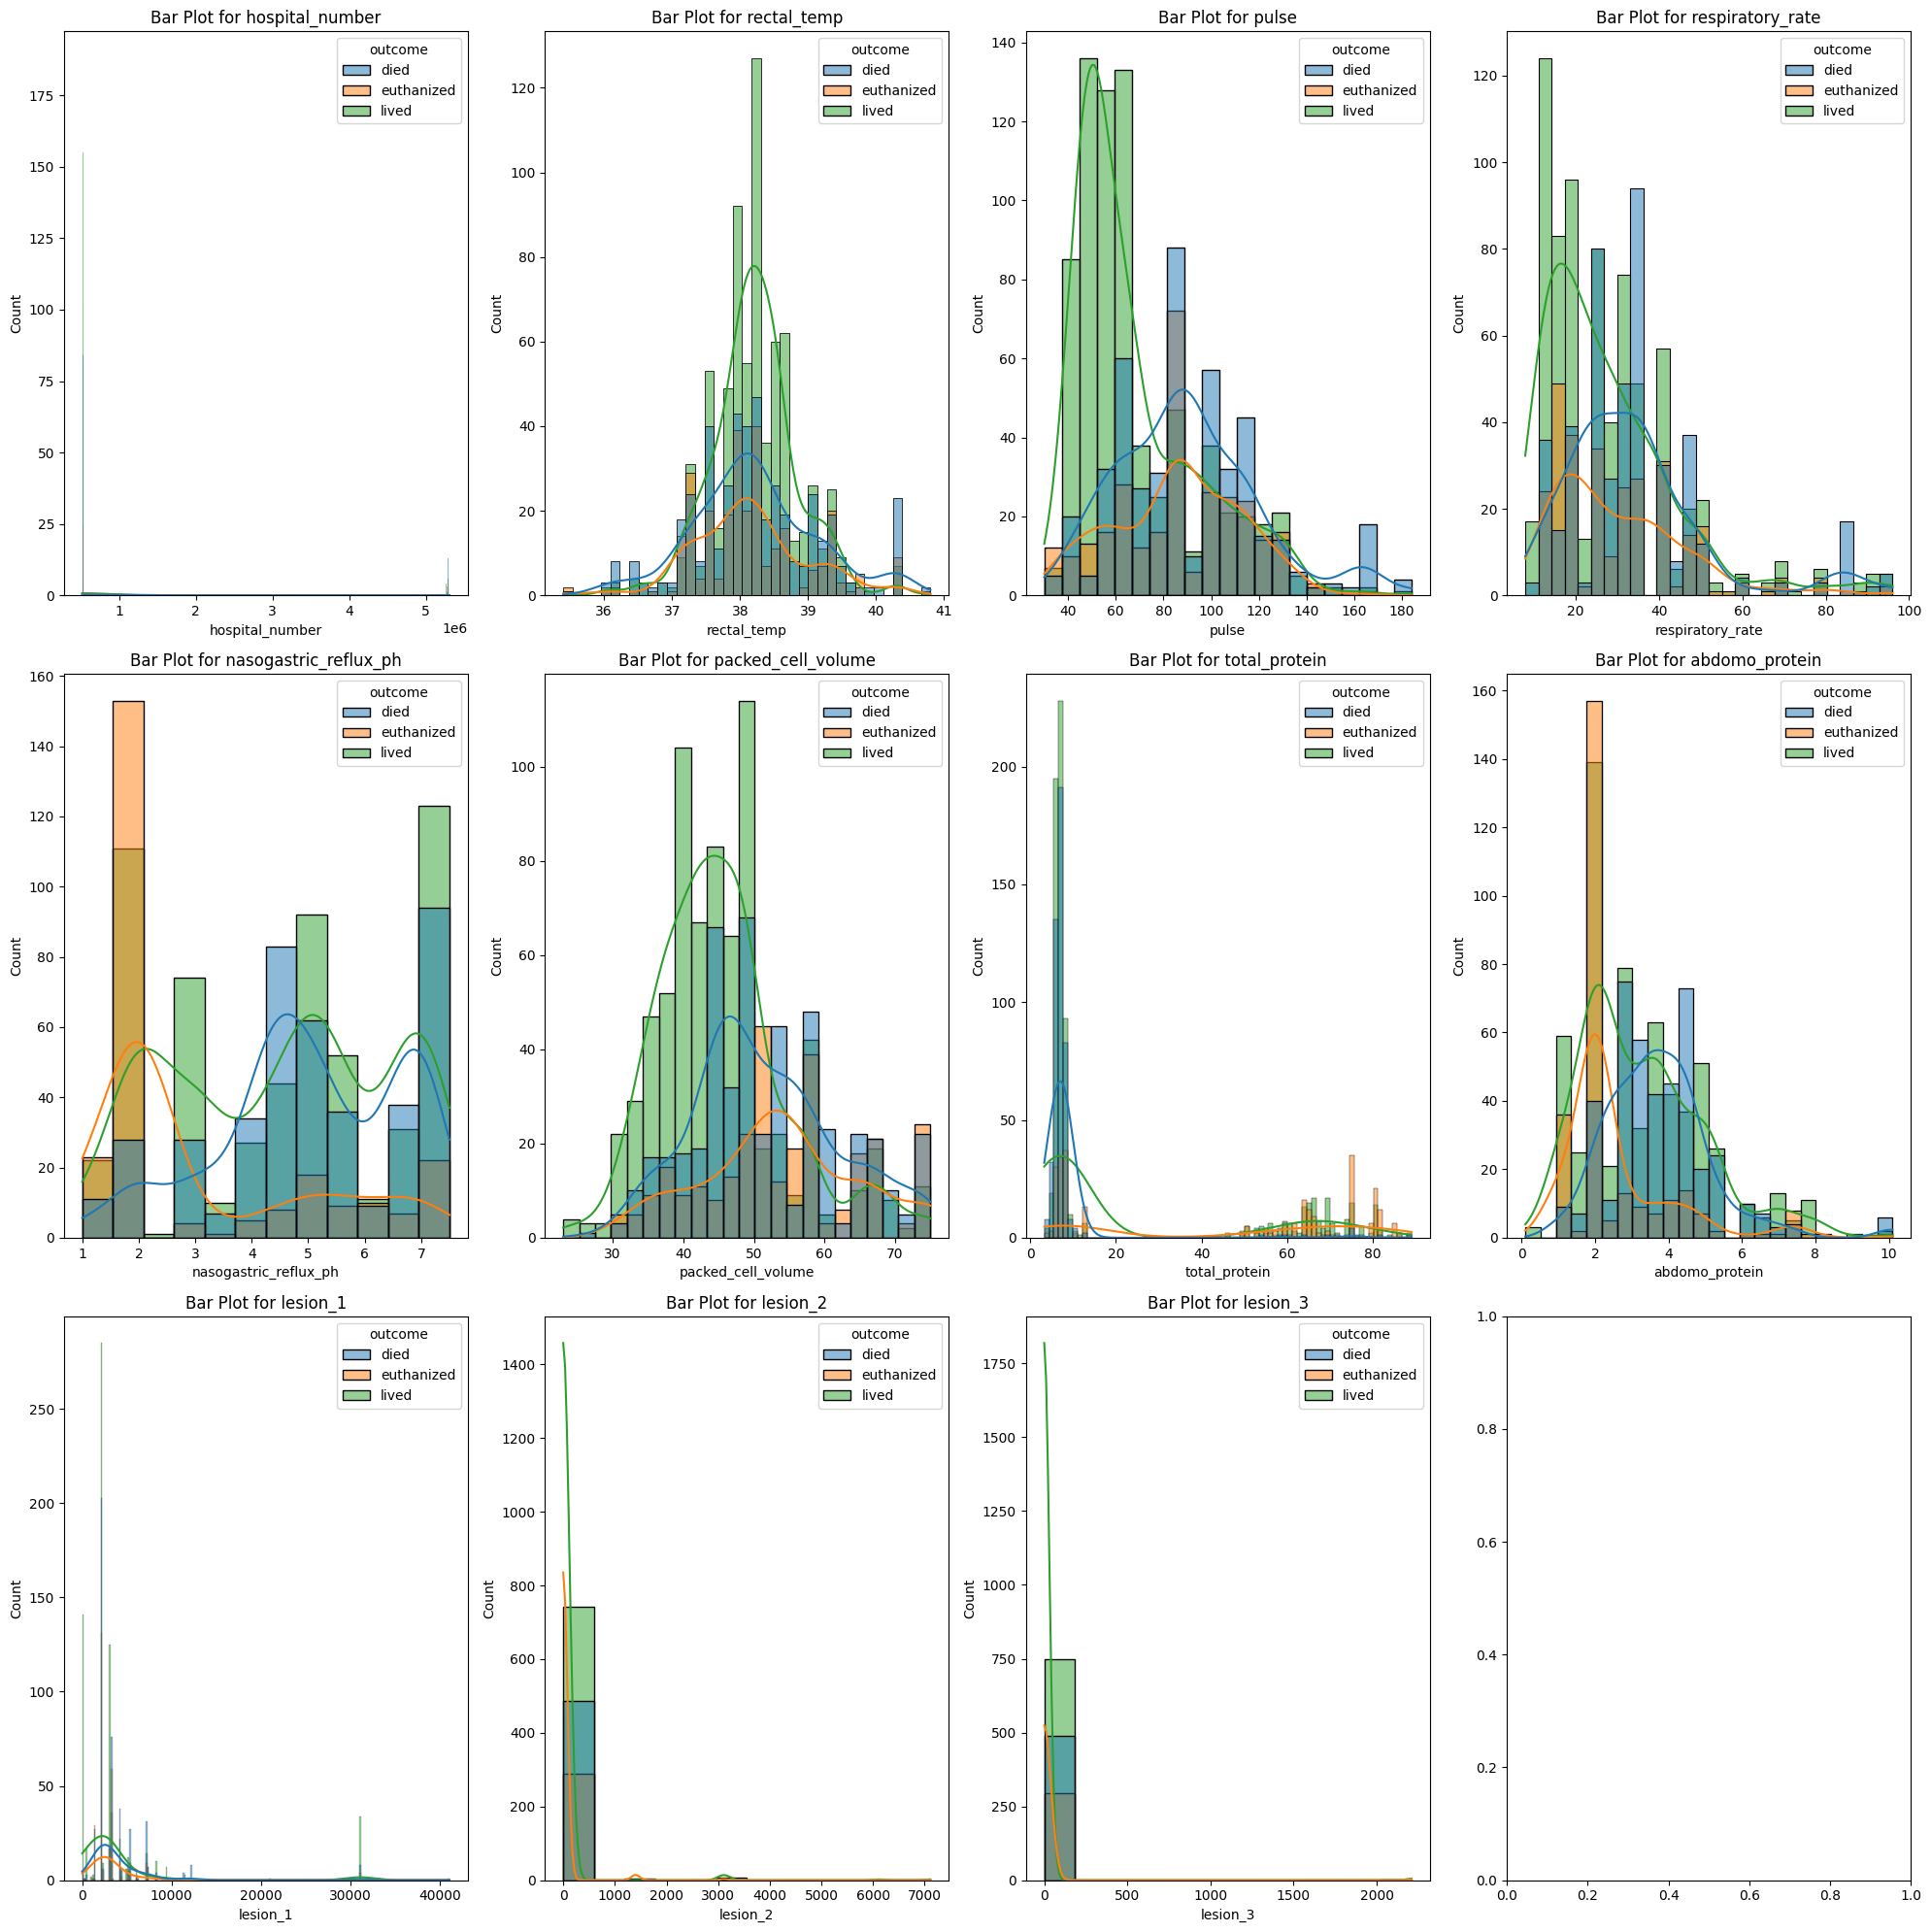

In [109]:

print(len(numeric_cols))
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
# Flatten the axes array for easier iteration
axes = axes.flatten()
for i, cat in enumerate(numeric_cols):
    sns.histplot(x=X[cat], hue=y, ax=axes[i], kde=True)
    axes[i].set_title(f"Bar Plot for {cat}")
plt.tight_layout()
# Show the plots
plt.show()

hosptital number seems hard to exploit like this so we will drop it atm.

lesion_2 and lesion_3 almost always have the same value, so we drop them.

In [110]:
to_drop = ['hospital_number', 'lesion_2', 'lesion_3']
try: 
    X.drop(columns=to_drop, inplace=True)
except KeyError:
    print("Columns already dropped")
try:
    X_test.drop(columns=to_drop, inplace=True)
except KeyError:
    print("Columns already dropped")

## Replacing missing value

We will replace missing values by the most frequent ones for categories, and with the median for numerical values

In [111]:
# TODO try both with median for numerical
for i in X.columns:    
    X[i].fillna(X[i].mode()[0], inplace=True)
    X_test[i].fillna(X[i].mode()[0], inplace=True)
assert X.isna().sum().sum() == 0
assert X_test.isna().sum().sum() == 0

## Mapping

we then map our categories to our defined mapping

In [112]:
X[category_cols] = X[category_cols].apply(lambda x: x.map(category_mapping[x.name]))
X_test[category_cols] = X_test[category_cols].apply(lambda x: x.map(category_mapping[x.name]))
X.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,cp_data
0,1,0,38.1,132.0,24.0,0,1,5,2,1,...,6.5,1,4,57.0,8.5,1,3.4,1,2209,0
1,1,0,37.5,88.0,12.0,0,2,4,2,2,...,2.0,0,4,33.0,64.0,1,2.0,1,2208,0
2,1,0,38.3,120.0,28.0,0,1,2,0,5,...,3.5,0,3,37.0,6.4,1,3.4,1,5124,0
3,1,0,37.1,72.0,30.0,1,1,2,2,2,...,2.0,1,4,53.0,7.0,2,3.9,1,2208,1
4,0,0,38.0,52.0,48.0,2,2,0,0,3,...,7.0,2,2,47.0,7.3,2,2.6,0,0,1


In [113]:
X_test.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,cp_data
id,,,,,,,,,,,,,,,,,,,,,
1235,0,0,38.6,40.0,20.0,2,2,0,0,2,...,7.0,2,4,42.0,7.5,0,2.3,0,0,0
1236,1,0,38.2,112.0,48.0,0,1,1,2,1,...,3.5,1,4,44.0,6.0,1,2.6,0,2208,1
1237,1,0,37.7,66.0,12.0,0,2,3,0,2,...,3.0,2,4,31.5,6.0,2,1.6,1,2205,1
1238,0,0,37.1,88.0,20.0,0,1,4,0,1,...,2.0,0,3,75.0,81.0,1,1.0,1,1400,0
1239,1,0,38.3,50.0,12.0,0,2,1,0,2,...,3.0,1,4,37.0,6.8,2,2.6,1,2208,1


In [114]:
y = y.map(outcome)
y.head()

0    1
1    2
2    0
3    0
4    0
Name: outcome, dtype: int64

In [115]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training

## CatBoost classifier

In [116]:
from catboost import CatBoostClassifier
import optuna
def objective_cat(trial):
    """Define the objective function"""

    params = {
        "iterations" : trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        "depth" : trial.suggest_int("depth", 1, 10),
        "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        "random_strength" : trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "od_type" : trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait" : trial.suggest_int("od_wait", 10, 50),
        "verbose" : False
    }


    model_cat = CatBoostClassifier(**params)
    model_cat.fit(X_train, y_train)
    y_pred = model_cat.predict(X_val)
    return accuracy_score(y_val,y_pred)

/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [117]:
study_cat = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_cat.optimize(objective_cat, n_trials=50,show_progress_bar=True)

[I 2023-10-01 16:47:37,587] A new study created in memory with name: no-name-40a4c544-0644-4ce3-8a9a-315f91fbcaf5
Best trial: 1. Best value: 0.762215: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


In [118]:
cat = CatBoostClassifier(**study_cat.best_params, verbose=False)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, y_pred))

Accuracy:  0.762214983713355


## LightGBM classifier

In [121]:
!pip install lightgbm --quiet
!pip install optuna --quiet

In [122]:
from lightgbm import LGBMClassifier
import optuna


def objective_lgb(trial):
    """Define the objective function"""

    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss', 
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
    }


    model_lgb = LGBMClassifier(**params)
    model_lgb.fit(X_train, y_train)
    y_pred = model_lgb.predict(X_val)
    return accuracy_score(y_val,y_pred)

In [ ]:
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=50,show_progress_bar=True)

In [126]:
print('Best parameters', study_lgb.best_params)

Best parameters {'max_depth': 1, 'learning_rate': 0.7610285491386273, 'n_estimators': 1180, 'min_child_weight': 10, 'subsample': 0.7829876618596705, 'colsample_bytree': 0.4208393658100096, 'reg_alpha': 0.9677867671665422, 'reg_lambda': 0.26533139020472524}


In [127]:
lgb = LGBMClassifier(**study_lgb.best_params)
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 1227, number of used features: 24
[LightGBM] [Info] Start training from score -0.720410
[LightGBM] [Info] Start training from score -1.146181
[LightGBM] [Info] Start training from score -1.631689
Accuracy:  0.7882736156351792


In [128]:
y_pred = lgb.predict(X_test)
y_pred = pd.Series(y_pred.flatten()).map(outcome_reverse)
# convert to a dataframe
submission = pd.DataFrame({'id': X_test.index, 'outcome': y_pred})
submission.to_csv('data/submission_hope_lgb.csv', index=False)

## XGBoost Classifier

In [129]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import optuna
def objective_xg(trial):
    """Define the objective function"""

    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 700),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 0.5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
    model_xgb = XGBClassifier(**params)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_val)
    return accuracy_score(y_val,y_pred)

In [130]:
study_xgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(objective_xg, n_trials=50,show_progress_bar=True)

[I 2023-10-01 16:53:39,525] A new study created in memory with name: no-name-9076f84b-3257-4633-92b2-ba2bbcfabc61
Best trial: 13. Best value: 0.788274: 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


In [131]:
xgb = XGBClassifier(**study_xgb.best_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, y_pred))

Accuracy:  0.7882736156351792


In [132]:
y_pred = xgb.predict(X_test)
y_pred = pd.Series(y_pred.flatten()).map(outcome_reverse)
# convert to a dataframe
submission = pd.DataFrame({'id': X_test.index, 'outcome': y_pred})
submission.to_csv('data/submission_hope_xgb.csv', index=False)

In [133]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('cat', cat),
                                      ('lgbm', lgb), 
                                      ('xgb', xgb)], voting='soft')
voting.fit(X_train,y_train)
voting_pred = voting.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, voting_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 1227, number of used features: 24
[LightGBM] [Info] Start training from score -0.720410
[LightGBM] [Info] Start training from score -1.146181
[LightGBM] [Info] Start training from score -1.631689
Accuracy:  0.7785016286644951


In [135]:
y_pred = voting.predict(X_test)
y_pred = pd.Series(y_pred.flatten()).map(outcome_reverse)
# convert to a dataframe
submission = pd.DataFrame({'id': X_test.index, 'outcome': y_pred})
submission.to_csv('data/submission_hope_voting.csv', index=False)